In [1]:
import os
os.chdir('public/itmo-sai-rag')

## Imports 

In [5]:
import json
import pandas as pd
from tqdm.notebook import tqdm
from sentence_transformers import SentenceTransformer, losses, InputExample
from sentence_transformers.losses import ContrastiveTensionDataLoader
from torch.utils.data import DataLoader
from langchain_chroma import Chroma
from langchain.docstore.document import Document
from utils import create_documents

/opt/conda/lib/python3.10/site-packages/sentence_transformers/cross_encoder/CrossEncoder.py:11: TqdmExperimentalWarning: Using `tqdm.autonotebook.tqdm` in notebook mode. Use `tqdm.tqdm` instead to force console mode (e.g. in jupyter console)
  from tqdm.autonotebook import tqdm, trange


## Train

In [3]:
model_path = 'intfloat/multilingual-e5-base'
model_name = model_path.split('/')[-1]

In [4]:
EPOCHS = 1

In [6]:
with open('data/otraslevye_docs_gost.json') as f:
    chunks = json.load(f)

In [7]:
documents = create_documents(chunks)
ids = chunks['ids']

<Axes: >

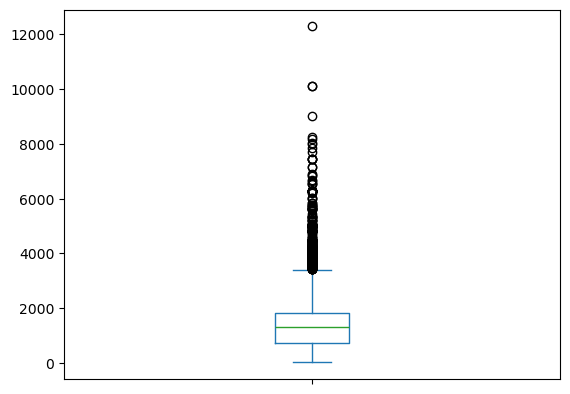

In [8]:
pd.Series(chunks['documents']).apply(len).plot.box()

In [9]:
train_examples = [InputExample(texts=[d, d]) for d in chunks['documents']]

In [11]:
model = SentenceTransformer(model_path)

In [12]:
train_dataloader = DataLoader(train_examples, shuffle=True, batch_size=4)

In [13]:
# train_dataloader = ContrastiveTensionDataLoader(train_examples, batch_size=3, pos_neg_ratio=3)

In [14]:
train_loss = losses.ContrastiveTensionLossInBatchNegatives(model=model)

In [15]:
# train_loss = losses.ContrastiveTensionLoss(model=model)

In [5]:
model_name = f'{model_name}_finetuned_{EPOCHS}_epch'
model_name

'multilingual-e5-base_finetuned_1_epch'

In [ ]:
model.fit(
    [(train_dataloader, train_loss)],
    epochs=EPOCHS
)

Step,Training Loss
500,0.088300
1000,0.013500
1500,0.005900
2000,0.004300
2500,0.004000


In [6]:
model_path = f'models/{model_name}'
model_path

'models/multilingual-e5-base_finetuned_1_epch'

In [ ]:
model.save_pretrained(model_path)

## Evaluate

In [6]:
from langchain.embeddings import HuggingFaceEmbeddings
from langchain_community.retrievers import BM25Retriever
from utils import find_hit

In [7]:
qa_df = pd.read_csv('data/test_qa_hyde_docs.csv')

In [8]:
qa_df.head()

,question,answer,context,akela_answer,reranked_paragraphs,hyde_doc
0,Какие физико-химические свойства характеризуют...,\nФизико-химические свойства конденсата включа...,компонентный состав и физико-химические свойст...,Физико-химические свойства конденсата включаю...,['физико-химические свойства газа в пластовых ...,"Конденсат, согласно ГОСТ 10688-2014 ""Конденсат..."
1,Какие физико-химические свойства пластовых вод...,\nВ документе описаны следующие физико-химичес...,компонентный состав и физико-химические свойст...,В документе описаны следующие физико-химическ...,['компонентный состав и физико-химические свой...,"В ГОСТ 12897-2019 ""Пластовые воды. Технические..."
2,Какие свойства пород-коллекторов и их взаимосв...,\nВ документе подробно описываются свойства по...,компонентный состав и физико-химические свойст...,В документе упоминаются следующие свойства по...,['компонентный состав и физико-химические свой...,"В соответствии с ГОСТом 12.2.007-2014 ""Породы-..."
3,Что служит критерием опасности коррозии для тр...,\nКритерием опасности коррозии для трубопровод...,"Примечания Для трубопроводов тепловых сетей, п...",Критерием опасности коррозии для трубопроводо...,"['Примечания Для трубопроводов тепловых сетей,...","В соответствии с ГОСТ 1629-2012 ""Тепловые сети..."
4,Как оценивается биокоррозия в соответствии с д...,\nВоздействие фактора биокоррозии оценивается ...,"Примечания Для трубопроводов тепловых сетей, п...",Биокоррозия оценивается на основании следующи...,"['Примечания Для трубопроводов тепловых сетей,...","В соответствии с ГОСТом ""Биокоррозия. Методы и..."


In [10]:
chroma_path = f'db/chroma_langchain_db_{model_name}'
chroma_path

'db/chroma_langchain_db_multilingual-e5-base_finetuned_1_epch'

In [11]:
model_kwargs = {"device": "cuda"}
encode_kwargs = {'normalize_embeddings': True}
embeddings = HuggingFaceEmbeddings(model_name=model_path, model_kwargs=model_kwargs, encode_kwargs=encode_kwargs)

/tmp/ipykernel_107282/2839606295.py:3: LangChainDeprecationWarning: The class `HuggingFaceEmbeddings` was deprecated in LangChain 0.2.2 and will be removed in 1.0. An updated version of the class exists in the langchain-huggingface package and should be used instead. To use it run `pip install -U langchain-huggingface` and import as `from langchain_huggingface import HuggingFaceEmbeddings`.
  embeddings = HuggingFaceEmbeddings(model_name=model_path, model_kwargs=model_kwargs, encode_kwargs=encode_kwargs)


In [12]:
vectordb = Chroma(
    collection_name="otraslevye_docs_gost",
    embedding_function=embeddings,
    persist_directory=chroma_path
)

In [18]:
for document, id in tqdm(zip(documents, ids), total=len(documents)):
    vectordb.add_documents(documents=[document], ids=[id])

  0%|          | 0/25286 [00:00<?, ?it/s]

In [13]:
retriever = vectordb.as_retriever(search_kwargs={"k": 3})

In [14]:
# BM25 Retriever
chunks = vectordb.get()
documents = create_documents(chunks)
retriever = BM25Retriever.from_documents(documents, k=3)

In [14]:
retrieved_documents = []

for q in tqdm(qa_df['hyde_doc']):
    retrieved_documents.append([d.page_content for d in retriever.invoke(q)])
    
qa_df['retrieved_documents'] = retrieved_documents

  0%|          | 0/397 [00:00<?, ?it/s]

In [18]:
qa_df['hitrate'] = qa_df.apply(lambda x: find_hit(x['context'], x['retrieved_documents'], prefix_char=None), axis=1)

In [19]:
qa_df['hitrate'].value_counts()

hitrate
0.0    46
1.0    26
2.0    15
Name: count, dtype: int64

In [20]:
qa_df.notna().sum() / len(qa_df)

question               1.000000
answer                 1.000000
context                1.000000
akela_answer           1.000000
reranked_paragraphs    1.000000
hyde_doc               1.000000
retrieved_documents    1.000000
hitrate                0.219144
dtype: float64